In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sympy import *
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import random
from matplotlib.pyplot import (
    colorbar,
    figure,
    imshow,
    plot,
    show,
    title,
    xlabel,
    xticks,
    ylabel,
    yticks,
)


In [155]:
filename = 'HR_data.csv'

df = pd.read_csv(filename, delimiter=",")

#Mapping for numbers
mapping = {'round_1': 1, 'round_2': 2, 'round_3': 3, 'round_4': 4}
df["Round"] = np.vectorize(mapping.get)(df["Round"])

mapping2 = {'phase1': 1, 'phase2': 2, 'phase3': 3}
df["Phase"] = np.vectorize(mapping2.get)(df["Phase"])

mapping3 = {'D1_1': 1, 'D1_2': 2,}
df["Cohort"] = np.vectorize(mapping3.get)(df["Cohort"])

#Low, med & high: low < 5 < high
df["Frustrated"] = np.digitize(np.array(df["Frustrated"]), bins=[2,5])

df


,Unnamed: 0,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,0,77.965186,78.000,3.345290,73.23,83.37,22924.945,3,3,1,1,0,1
1,1,70.981097,70.570,2.517879,67.12,78.22,21930.400,3,2,1,1,2,1
2,2,73.371959,73.360,3.259569,67.88,80.22,21647.085,3,1,1,1,0,1
3,3,78.916822,77.880,4.054595,72.32,84.92,25258.905,2,3,1,1,0,1
4,4,77.322226,74.550,6.047603,70.52,90.15,23890.565,2,2,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,163,73.594539,72.380,9.474556,57.43,93.53,21482.985,4,2,14,0,2,2
164,164,57.839897,54.130,6.796647,52.97,74.14,16825.740,4,1,14,0,0,2
165,165,64.237295,65.195,3.589241,58.97,72.63,18691.065,1,3,14,0,0,2
166,166,70.834320,70.440,2.391160,66.65,76.07,20753.005,1,2,14,0,1,2


### Correlation coefficients

In [3]:
corr_matrix = df[["HR_Mean", "HR_Median", "HR_std", "HR_Min", "HR_Max", "HR_AUC", "Frustrated"]].corr()
corr_with_target = corr_matrix['Frustrated'].abs().sort_values(ascending=False)
print(corr_with_target)

Frustrated    1.000000
HR_Mean       0.098341
HR_Max        0.088312
HR_Median     0.085577
HR_std        0.075354
HR_AUC        0.068420
HR_Min        0.004971
Name: Frustrated, dtype: float64


### Checking for normal distribution

In [169]:
#Checking for normal distribution
from scipy.stats import shapiro
attributes = ["HR_Mean", "HR_Median", "HR_std", "HR_Min", "HR_Max", "HR_AUC"]
for i in attributes: 
    data = df[i]

    stat, p_value = shapiro(data)
    print(f'Shapiro-Wilk test for normality for {i} - Frustrated group: stat={stat}, p-value={p_value}')

Shapiro-Wilk test for normality for HR_Mean - Frustrated group: stat=0.9880087375640869, p-value=0.16310925781726837
Shapiro-Wilk test for normality for HR_Median - Frustrated group: stat=0.9865574240684509, p-value=0.10706265270709991
Shapiro-Wilk test for normality for HR_std - Frustrated group: stat=0.8340593576431274, p-value=1.5454714331203379e-12
Shapiro-Wilk test for normality for HR_Min - Frustrated group: stat=0.9880374670028687, p-value=0.1644594371318817
Shapiro-Wilk test for normality for HR_Max - Frustrated group: stat=0.9174203276634216, p-value=3.681529037180553e-08
Shapiro-Wilk test for normality for HR_AUC - Frustrated group: stat=0.9502153992652893, p-value=1.1786708455474582e-05


### Datadescription

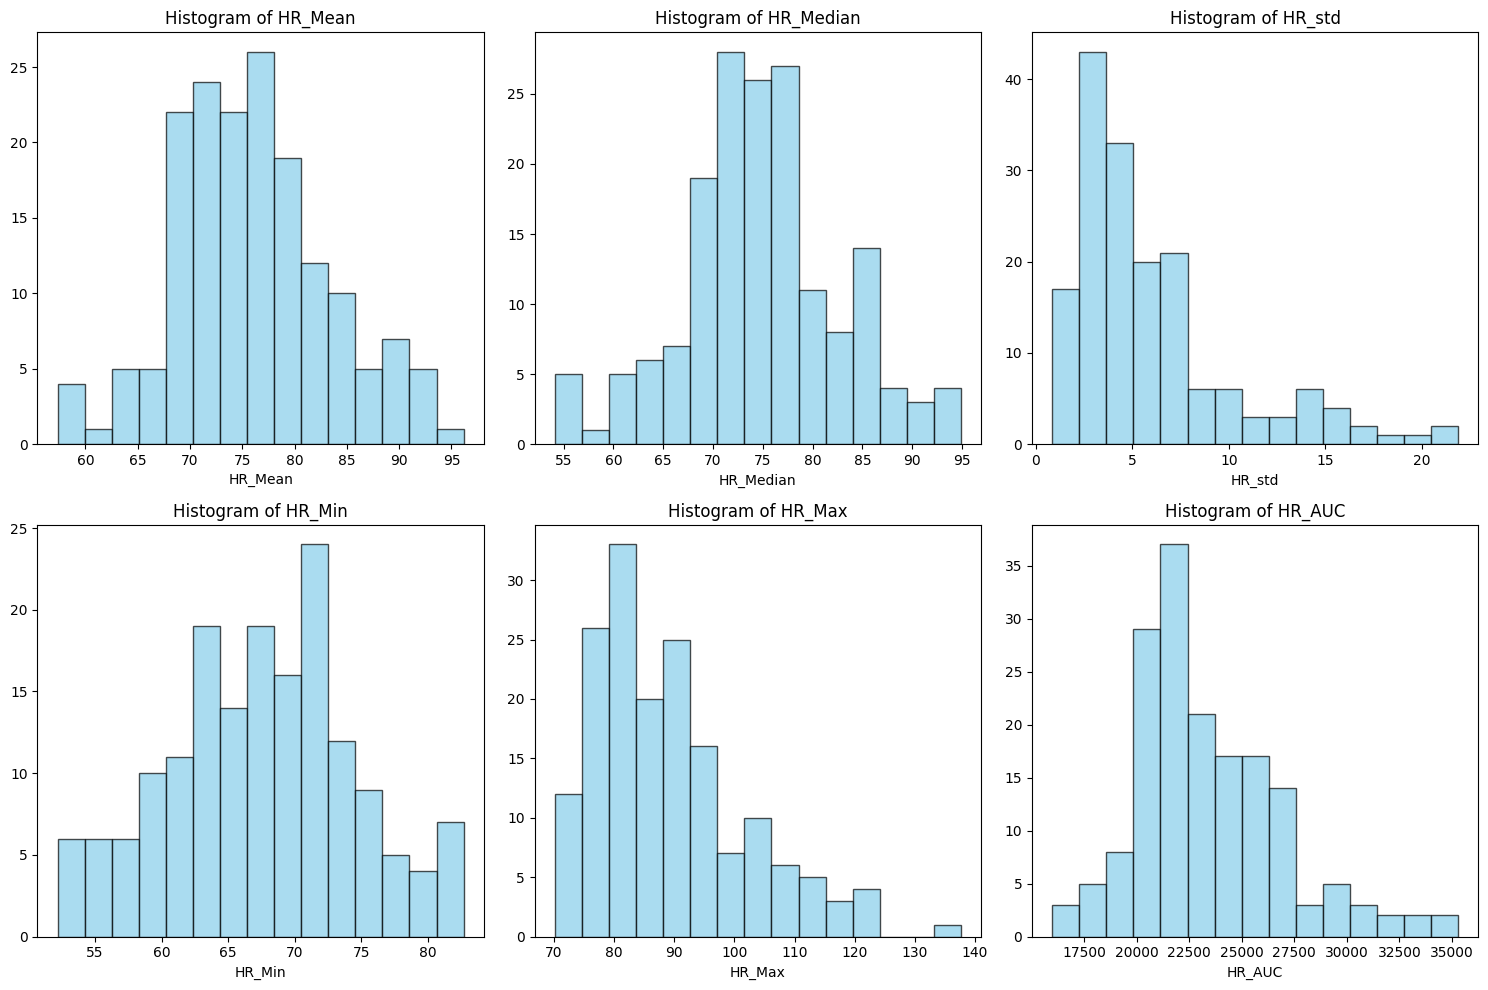

In [170]:
num_attributes = len(attributes)
nrows = (num_attributes + 2) // 3 
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(attributes):
    axes[i].hist(df[col], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)

for j in range(num_attributes, nrows * ncols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Calculating average frustration across phases and Friedmann Chi square test

In [159]:
for r in [1,2,3,4]: 
    print(f"----Round {r}")
    phase1 = df[(df['Round'] == r) & (df['Phase'] == 1)]
    phase2 = df[(df['Round'] == r) & (df['Phase'] == 2)]
    phase3 = df[(df['Round'] == r) & (df['Phase'] == 3)]


    p1 = sum(phase1["Frustrated"]) / len(phase1["Frustrated"])
    p2 = sum(phase2["Frustrated"]) / len(phase2["Frustrated"])
    p3 = sum(phase3["Frustrated"]) / len(phase3["Frustrated"]) 
    
    frustration = [p1,p2,p3]

    n = len(phase1["Frustrated"])
    z = 1.96
    conf_intervals = []
    for i,p in enumerate(frustration): 
        sd = sqrt(p*(1-p)/n)
        conf = [p-z*sd, p+z*sd]
        conf = [round(c, 3) for c in conf]
        print(f"Accuracy of {frustration[i]}", conf)
    print("Avg. frustration: ",p1)
    print("Avg. frustration: ",p2)
    print("Avg. frustration: ",p3)

    
    #Kruskal wallis and one way anova to test for signififcant difference in means: 
    from scipy.stats import f_oneway
    from scipy.stats.mstats import kruskal
    from scipy.stats import friedmanchisquare
    attributes = ["HR_Mean", "HR_Median", "HR_Min", "HR_AUC", "HR_std", "HR_Max"]

    print("----Firedmanchisquare ----")
    for i in attributes: 
        p1 = phase1[i]
        p2 = phase2[i]
        p3 = phase3[i]

        f_statistic, p_value = friedmanchisquare(np.array(p1), np.array(p2), np.array(p3))
        if p_value <= 0.05:
            print(f'F-statistic for {i}: {f_statistic}, p-value: {p_value}', "SIGNIFICANT")
        else: 
            print(f'F-statistic for {i}: {f_statistic}, p-value: {p_value}')
            
    print("  ")

----Round 1
Accuracy of 0.35714285714285715 [0.106, 0.608]
Accuracy of 0.8571428571428571 [0.674, 1.040]
Accuracy of 0.5 [0.238, 0.762]
Avg. frustration:  0.35714285714285715
Avg. frustration:  0.8571428571428571
Avg. frustration:  0.5
----Firedmanchisquare ----
F-statistic for HR_Mean: 3.571428571428555, p-value: 0.16767724875179846
F-statistic for HR_Median: 8.714285714285694, p-value: 0.012814949534927386 SIGNIFICANT
F-statistic for HR_Min: 0.5714285714285552, p-value: 0.7514772930752922
F-statistic for HR_AUC: 8.714285714285694, p-value: 0.012814949534927386 SIGNIFICANT
F-statistic for HR_std: 4.0, p-value: 0.1353352832366127
F-statistic for HR_Max: 3.857142857142861, p-value: 0.14535570123384634
  
----Round 2
Accuracy of 0.35714285714285715 [0.106, 0.608]
Accuracy of 1.3571428571428572 [1.357 - 0.365*I, 1.357 + 0.365*I]
Accuracy of 0.5714285714285714 [0.312, 0.831]
Avg. frustration:  0.35714285714285715
Avg. frustration:  1.3571428571428572
Avg. frustration:  0.5714285714285714
-

### Log transforming data

In [34]:
df["HR_std"] = np.log(np.array(df["HR_std"]))
df["HR_AUC"] = np.log(np.array(df["HR_AUC"]))

Confusion Matrix log:
[[46 28  0]
 [45 25  0]
 [16  8  0]]
Test acc:  0.4226190476190476
train acc: 0.5064102564102564


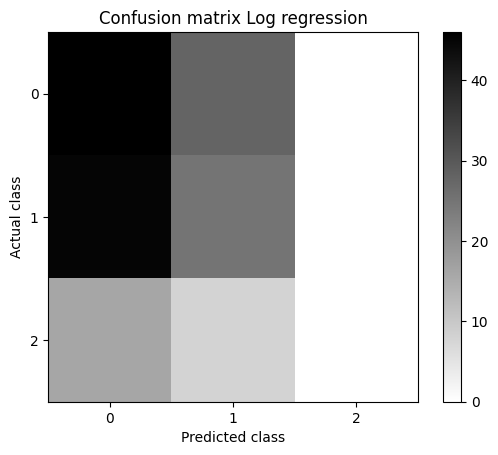

Confusion Matrix decision tree:
[[18 56  0]
 [11 59  0]
 [ 2 22  0]]
Test acc:  0.4583333333333333
train acc: 0.5677655677655677


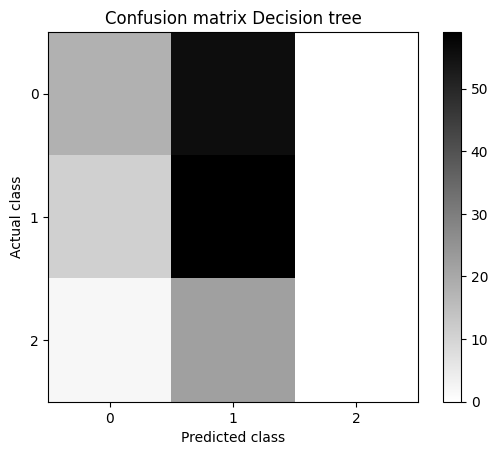

Confusion Matrix Random Forest:
[[35 39  0]
 [35 35  0]
 [ 8 16  0]]
Test acc:  0.4166666666666667
train acc: 0.7124542124542125


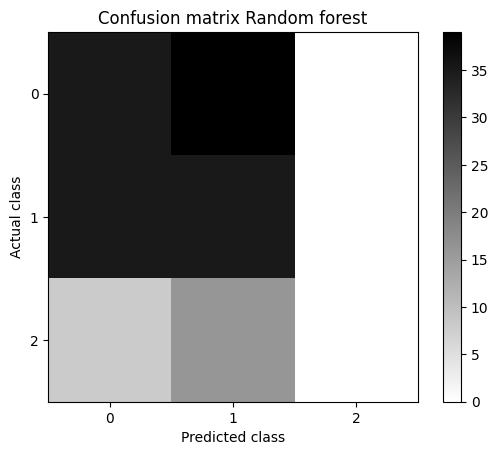

Baseline:
[[37 37  0]
 [64  6  0]
 [19  5  0]]
acc:  0.25595238095238093


In [171]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

unique_id = (df["Individual"].unique()).tolist()

y_total_test = np.empty(0)
log_pred = np.empty(0)
tree_pred = np.empty(0)
forest_pred = np.empty(0)
baseline_pred = np.empty(0)

y_total_train = np.empty(0)
log_train = np.empty(0)
tree_train = np.empty(0)
forest_train = np.empty(0)

samples = random.sample(unique_id, 14)

for i in samples: #CV 

    index = [i]
    train = df[~df['Individual'].isin(index)]
    test = df[df['Individual'].isin(index)]
    
    #Converting data
    X_train = np.array(train[["HR_Mean","HR_Median", "HR_AUC", "HR_std"]]).astype("float64")
    y_train = np.array(train)[:,-2].astype("uint8") 
    X_test = np.array(test[["HR_Mean","HR_Median", "HR_AUC","HR_std"]]).astype("float64")
    y_test = np.array(test)[:,-2].astype("uint8")    

    y_total_test = np.append(y_total_test, y_test)
    y_total_train = np.append(y_total_train, y_train)

    #Scaling 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Logistic regression for Multiclassification
    mdl = LogisticRegression(penalty="l2", multi_class="auto", C= 0.5)
    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T

    log_pred = np.append(log_pred, y_test_est)
    log_train = np.append(log_train, y_train_est)
    
    #Deciciontree
    tree = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10)
    tree.fit(X_train, y_train)

    y_train_est = tree.predict(X_train).T
    y_test_est = tree.predict(X_test).T

    tree_pred = np.append(tree_pred, y_test_est)
    tree_train = np.append(tree_train, y_train_est)

    # Random Forest Classifier
    rf_model = RandomForestClassifier(max_depth=4, n_estimators=100)
    rf_model.fit(X_train, y_train)

    y_train_est = rf_model.predict(X_train)
    y_pred_rf = rf_model.predict(X_test)

    forest_pred = np.append(forest_pred, y_pred_rf)
    forest_train = np.append(forest_train, y_train_est)

    #BASELINE random guesser
    baseline_pred = np.append(baseline_pred, np.repeat(np.bincount(y_train).argmax(),len(y_test)))


#CONFUSION MATRIX 
conf_matrix = confusion_matrix(y_total_test, log_pred)
accuracy_log = accuracy_score(y_total_test, log_pred)
error_rate = 1 - accuracy_log
print("Confusion Matrix log:")
print(conf_matrix)
print("Test acc: ",accuracy_log)
print("train acc:", accuracy_score(y_total_train, log_train))

figure(2)
imshow(conf_matrix, cmap="binary", interpolation="None")
colorbar()
xticks(range(3))
yticks(range(3))
xlabel("Predicted class")
ylabel("Actual class")
title(
    "Confusion matrix Log regression".format(accuracy_log, error_rate)
)
show()

conf_matrix = confusion_matrix(y_total_test, tree_pred)
accuracy_tree = accuracy_score(y_total_test, tree_pred)
error_rate = 1 - accuracy_tree
print("Confusion Matrix decision tree:")
print(conf_matrix)
print("Test acc: ",accuracy_tree)
print("train acc:", accuracy_score(y_total_train, tree_train))

figure(2)
imshow(conf_matrix, cmap="binary", interpolation="None")
colorbar()
xticks(range(3))
yticks(range(3))
xlabel("Predicted class")
ylabel("Actual class")
title(
    "Confusion matrix Decision tree".format(accuracy_tree, error_rate)
)
show()

conf_matrix = confusion_matrix(y_total_test, forest_pred)
accuracy_forest = accuracy_score(y_total_test, forest_pred)
error_rate = 1 - accuracy_forest
print("Confusion Matrix Random Forest:")
print(conf_matrix)
print("Test acc: ",accuracy_forest)
print("train acc:", accuracy_score(y_total_train, forest_train))

figure(2)
imshow(conf_matrix, cmap="binary", interpolation="None")
colorbar()
xticks(range(3))
yticks(range(3))
xlabel("Predicted class")
ylabel("Actual class")
title(
    "Confusion matrix Random forest".format(accuracy_forest, error_rate)
)
show()

conf_matrix = confusion_matrix(y_total_test, baseline_pred)
accuracy_base = accuracy_score(y_total_test, baseline_pred)
error_rate = 1 - accuracy_base
print("Baseline:")
print(conf_matrix)
print("acc: ",accuracy_base)



### Computing model accuracies with noise in dataset

In [172]:

unique_id = (df["Individual"].unique()).tolist()

y_total_test = np.empty(0)
log_pred = np.empty(0)
tree_pred = np.empty(0)
forest_pred = np.empty(0)
baseline_pred = np.empty(0)

y_total_train = np.empty(0)
log_train = np.empty(0)
tree_train = np.empty(0)
forest_train = np.empty(0)

samples = random.sample(unique_id, 14)

#NOISE: 
noise_factor = 0.1
df[["HR_Mean","HR_Median", "HR_AUC", "HR_std"]] += noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(168,1))

for i in samples: #CV 

    index = [i]
    train = df[~df['Individual'].isin(index)]
    test = df[df['Individual'].isin(index)]
    
    #Converting data
    X_train = np.array(train[["HR_Mean","HR_Median", "HR_AUC", "HR_std"]]).astype("float64")
    y_train = np.array(train)[:,-2].astype("uint8") 
    X_test = np.array(test[["HR_Mean","HR_Median", "HR_AUC","HR_std"]]).astype("float64")
    y_test = np.array(test)[:,-2].astype("uint8")    

    y_total_test = np.append(y_total_test, y_test)
    y_total_train = np.append(y_total_train, y_train)

    #Scaling 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Logistic regression for Multiclassification
    mdl = LogisticRegression(penalty="l2", multi_class="auto", C= 0.5)
    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T

    log_pred = np.append(log_pred, y_test_est)
    log_train = np.append(log_train, y_train_est)
    
    #Deciciontree
    tree = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10)
    tree.fit(X_train, y_train)

    y_train_est = tree.predict(X_train).T
    y_test_est = tree.predict(X_test).T

    tree_pred = np.append(tree_pred, y_test_est)
    tree_train = np.append(tree_train, y_train_est)

    # Random Forest Classifier
    rf_model = RandomForestClassifier(max_depth=4, n_estimators=100)
    rf_model.fit(X_train, y_train)

    y_train_est = rf_model.predict(X_train)
    y_pred_rf = rf_model.predict(X_test)

    forest_pred = np.append(forest_pred, y_pred_rf)
    forest_train = np.append(forest_train, y_train_est)

    #BASELINE random guesser
    baseline_pred = np.append(baseline_pred, np.repeat(np.bincount(y_train).argmax(),len(y_test)))


#CONFUSION MATRIX 
conf_matrix = confusion_matrix(y_total_test, log_pred)
accuracy_log = accuracy_score(y_total_test, log_pred)
error_rate = 1 - accuracy_log
print("log regression:")

print("Test acc: ",accuracy_log)
print("train acc:", accuracy_score(y_total_train, log_train))

conf_matrix = confusion_matrix(y_total_test, tree_pred)
accuracy_tree = accuracy_score(y_total_test, tree_pred)
error_rate = 1 - accuracy_tree
print("decision tree:")

print("Test acc: ",accuracy_tree)
print("train acc:", accuracy_score(y_total_train, tree_train))

conf_matrix = confusion_matrix(y_total_test, forest_pred)
accuracy_forest = accuracy_score(y_total_test, forest_pred)
error_rate = 1 - accuracy_forest
print("Random Forest:")

print("Test acc: ",accuracy_forest)
print("train acc:", accuracy_score(y_total_train, forest_train))

log regression:
Test acc:  0.42857142857142855
train acc: 0.5105311355311355
decision tree:
Test acc:  0.35714285714285715
train acc: 0.5576923076923077
Random Forest:
Test acc:  0.4523809523809524
train acc: 0.7046703296703297


### Statistical evaluation

Accuracy of Logistic regression [0.348, 0.497]
Accuracy of Decision tree [0.331, 0.479]
Accuracy of Random forest [0.325, 0.473]
Accuracy of Baseline [0.190, 0.322]


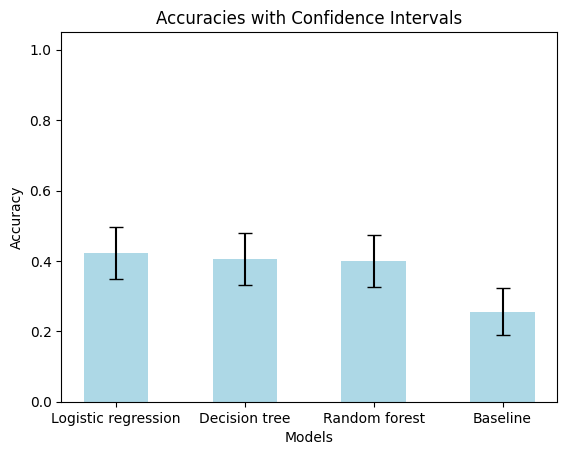

In [149]:
# Assuming normal distribution
n = df.shape[0]
z = 1.96

labels = ["Logistic regression","Decision tree","Random forest","Baseline"]
accuracies = [accuracy_log, accuracy_tree, accuracy_forest, accuracy_base]

conf_intervals = []
for i,p in enumerate(accuracies): 
    sd = sqrt(p*(1-p)/n)
    conf = [p-z*sd, p+z*sd]
    conf = [round(c, 3) for c in conf]
    print(f"Accuracy of {labels[i]}", conf)
    conf_intervals.append(conf)

conf_intervals = np.array(conf_intervals)
lower_bounds = conf_intervals[:, 0]
upper_bounds = conf_intervals[:, 1]
errors = [accuracies - lower_bounds, upper_bounds - accuracies]

x = np.arange(len(labels))
width = 0.5

fig, ax = plt.subplots()
bars = ax.bar(x, accuracies, width, yerr=errors, capsize=5, color='lightblue')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title(f'Accuracies with Confidence Intervals')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)  # Setting the limit of y-axis to a little above 1 for better visibility

# Display the plot
plt.show()


## Mcnemar

In [93]:
from dtuimldmtools import mcnemar

#MCnemars test 
alpha = 0.05
print("---------------Log vs. Tree--------------")
[thetahat, CI, p] = mcnemar(np.array(y_total_test), np.array(log_pred), np.array(tree_pred), alpha=alpha)
print("theta = theta_A-theta_C point estimate", thetahat, " CI: ", CI, "p-value", p)

print("---------------Log vs. Forest--------------")
[thetahat, CI, p] = mcnemar(np.array(y_total_test), np.array(log_pred), np.array(forest_pred), alpha=alpha)
print("theta = theta_A-theta_C point estimate", thetahat, " CI: ", CI, "p-value", p)

print("---------------Forest vs. tree--------------")
[thetahat, CI, p] = mcnemar(np.array(y_total_test), np.array(forest_pred), np.array(tree_pred), alpha=alpha)
print("theta = theta_A-theta_C point estimate", thetahat, " CI: ", CI, "p-value", p)

---------------Log vs. Tree--------------
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[42. 29.]
 [35. 62.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.12841652238276746, 0.05729304737056129)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.5323087760278422
theta = theta_A-theta_C point estimate -0.03571428571428571  CI:  (-0.12841652238276746, 0.05729304737056129) p-value 0.5323087760278422
---------------Log vs. Forest--------------
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[52. 19.]
 [23. 74.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.0990169988327928, 0.05153137188051171)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.6439689563703723
theta = theta_A-theta_C point estimate -0.023809523809523808  CI:  (-0.0990169988327928, 0.05153137188051171) p-value 0.6439689563703723
---------------Forest vs. tree--------------
Re